<a href="https://colab.research.google.com/github/jullyoemmanuel/manutencao-preventiva/blob/main/eda_e_modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [149]:
!pip install session-info

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 KB 6.8 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8046 sha256=af4efd10f16dac712cbf5f8f3100e14d0b088daf69278e318ae150108904cff8
  Stored in directory: /root/.cache/pip/wheels/5c/1b/4d/111d73980c5c6a8e5e5905a19eccc34296cb359cac54c6c5b9
Successfully built session-info


In [150]:
import session_info
session_info.show()

In [151]:
# Salvando arquivo requirements.txt
!pip freeze > requirements.txt
!pip list --format=freeze > requirements.txt

# EDA - Análise exploratória de dados

## Desafio
O objetivo desse projeto é identificar quais máquinas apresentam potencial de falha tendo como base dados extraídos através de sensores durante o processo de manufatura.  Para isso vamos utilizar dois datasets: um dataset chamado <code>desafio_manutencao_preditiva_treino.csv</code> composto por 6667 linhas, 9 colunas de informação (features) e a variável a ser prevista (<code>“failure_type”</code>). 

O segundo dataset chamado de <code>desafio_manutencao_preditiva_teste.csv</code> possui 3333 linhas e 8 colunas e não possui a coluna <code>“failure_type”</code>. Então, o objetivo é prever essa coluna a partir dos dados.


## Documentação do dataset

O conjunto de dados consiste em 10.000 pontos de dados armazenados como linhas com 8 recursos em colunas:

* UID: identificador único que varia de 1 a 10000

* ID do produto: consistindo em uma letra L, M ou H para baixo (50% de todos os produtos), médio (30%) e alto (20%) como variantes de qualidade do produto e um número de série específico da variante
* tipo: apenas o tipo de produto L, M ou H da coluna 2

* temperatura do ar [K]: gerada usando um processo de passeio aleatório posteriormente normalizado para um desvio padrão de 2 K em torno de 300 K

* temperatura do processo [K]: gerada usando um processo de passeio aleatório normalizado para um desvio padrão de 1 K, adicionado à temperatura do ar mais 10 K.

* velocidade rotacional [rpm]: calculada a partir de uma potência de 2860 W, sobreposta com um ruído normalmente distribuído

* torque [Nm]: os valores de torque são normalmente distribuídos em torno de 40 Nm com SD = 10 Nm e sem valores negativos.

* desgaste da ferramenta [min]: As variantes de qualidade H/M/L adicionam 5/3/2 minutos de desgaste da ferramenta à ferramenta utilizada no processo.

Um rótulo de 'falha de máquina' que indica se a máquina falhou neste ponto de dados específico para qualquer um dos modos de falha a seguir é verdadeiro.

A falha da máquina consiste em cinco modos de falha independentes:

* falha de desgaste da ferramenta (TWF): a ferramenta será substituída ou falha em um tempo de desgaste da ferramenta selecionado aleatoriamente entre 200 - 240 minutos (120 vezes em nosso conjunto de dados). Neste momento, a ferramenta é substituída 69 vezes e falha 51 vezes (atribuídas aleatoriamente).

* falha de dissipação de calor (HDF): a dissipação de calor causa uma falha no processo, se a diferença entre a temperatura do ar e do processo for inferior a 8,6 K e a velocidade de rotação da ferramenta for inferior a 1380 rpm. Este é o caso de 115 pontos de dados.

* falha de energia (PWF): o produto do torque e da velocidade de rotação (em rad/s) é igual à energia necessária para o processo. Se esta potência estiver abaixo de 3500 W ou acima de 9000 W, o processo falha, o que ocorre 95 vezes em nosso conjunto de dados.

* falha de sobretensão (OSF): se o produto do desgaste da ferramenta e do torque exceder 11.000 minNm para a variante de produto L (12.000 M, 13.000 H), o processo falha devido à sobretensão. Isso é verdade para 98 pontos de dados.

* falhas aleatórias (RNF): cada processo tem uma chance de 0,1% de falhar independentemente de seus parâmetros de processo. Este é o caso de apenas 5 pontos de dados, menos do que o esperado para 10.000 pontos de dados em nosso conjunto de dados.

## Bibliotecas necessárias e informações importantes 

In [102]:
# Manipulação de dados
import pandas as pd

# Plotagem
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 100
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")

import plotly.offline as py
import plotly.figure_factory as ff
import plotly.graph_objs as go

# Leitura do arquivo desafio_manutencao_preditiva_treino.csv
data = pd.read_csv('/content/desafio_manutencao_preditiva_treino.csv')

# Primeiras cinco linhas do dataset
data.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,failure_type
0,1,M14860,M,298.1,308.6,1551,42.8,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,No Failure
2,5,L47184,L,298.2,308.7,1408,40.0,9,No Failure
3,6,M14865,M,298.1,308.6,1425,41.9,11,No Failure
4,7,L47186,L,298.1,308.6,1558,42.4,14,No Failure


In [103]:
# Formato dos dados
data.shape

(6667, 9)

In [104]:
# Informações relevantes
data.describe()

,udi,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
count,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000,6667.000000
mean,4994.589921,299.992515,309.992620,1537.419529,40.058512,108.098095
std,2896.125718,1.994710,1.488101,177.182908,9.950804,63.359915
min,1.000000,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,2496.500000,298.300000,308.800000,1422.500000,33.200000,54.000000
50%,4983.000000,300.000000,310.000000,1503.000000,40.200000,108.000000
75%,7510.500000,301.500000,311.100000,1612.000000,46.800000,162.000000
max,10000.000000,304.500000,313.800000,2886.000000,76.600000,251.000000


## Variáveis de interesse

É possível observar que o dataset <code>desafio_manutencao_preditiva_treino.csv</code> possui apenas as seguintes colunas como variáveis de interesse:
* <code>'type'</code>
* <code>'air_temperature_k'</code>
* <code>'process_temperature_k'</code>
* <code>'rotational_speed_rpm'</code>
* <code>'torque_nm'	</code>
* <code>'tool_wear_min'</code>
* <code>'failure_type'</code>

uma vez que <code>'udi'</code> e <code>'product_id'</code> são apenas códigos de identificação e não interferem nas nossas previsões. Das nossas variáveis de interesse, também vemos que <code>'type'</code> e <code>'failure_type'</code> são variáveis categóricas e o restante são variáveis numéricas. 

Sendo assim, ficamos com a seguinte estrutura de dados:

| Features | Labels |
|------------|------------------|
| type       | failure_type     |
| air_temperature_k         |   |
|process_temperature_k||
| rotational_speed_rpm         |      |
| torque_nm         |      |
|tool_wear_min||

In [105]:
# Selecionando apenas as variáveis de interesse
target = 'failure_type'
categ = ['type']
num = ['air_temperature_k', 'process_temperature_k',
'rotational_speed_rpm','torque_nm', 'tool_wear_min']

targets = data[['type',
'air_temperature_k',
'process_temperature_k',
'rotational_speed_rpm',
'torque_nm',
'tool_wear_min',
'failure_type']]

## Valores nulos

In [106]:
# Verificando se o dataset contém valores nulos
targets.isna().sum()

type                     0
air_temperature_k        0
process_temperature_k    0
rotational_speed_rpm     0
torque_nm                0
tool_wear_min            0
failure_type             0
dtype: int64

Não há valores nulos, então podemos dar continuidade a nossa análise.

## Matriz de correlação

Uma matriz de correlação ou <a href="https://seaborn.pydata.org/generated/seaborn.heatmap.html">Matriz de calor</a> é uma tabela que mostra o valor do coeficiente de correlação entre conjuntos de variáveis. Cada atributo do conjunto de dados é comparado com os outros atributos para descobrir o coeficiente de correlação. 

Aqui estamos buscando entender quais pares têm a correlação mais alta, já que esses pares praticamente representam a mesma variância do conjunto de dados, portanto, podem não ser tão significativos para a construção do modelo.

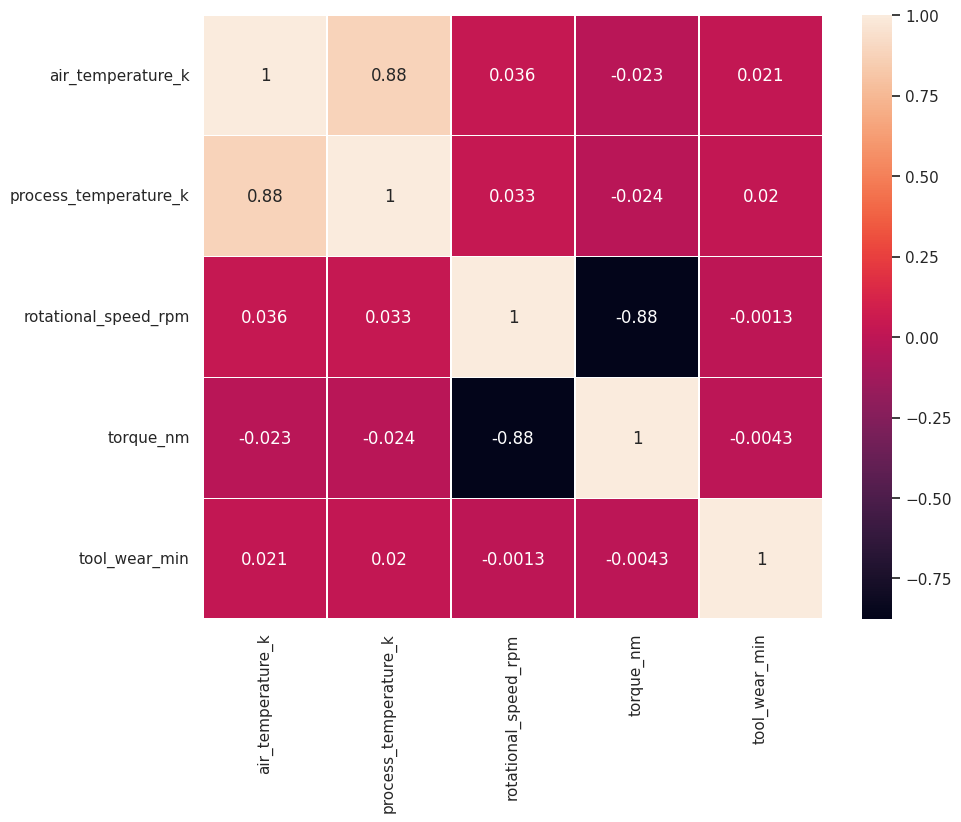

In [107]:
features = targets[categ+num]
sns.heatmap(features.corr(),annot=True,linewidths=0.2) #data.corr()-->correlation matrix
fig= plt.gcf()
fig.set_size_inches(10,8)
plt.show()

É possível observar que as variáveis <code>air_temperature_k</code> e <code>process_temperature_k</code> estão altamente correlacionadas positivamente, já as variáveis <code>rotational_speed_rpm</code> e <code>torque_nm</code> estão altamente correlacionadas negativamente. 

Variáveis com alta correlação são mais linearmente dependentes e, portanto, têm quase o mesmo efeito na variável dependente. Portanto, quando dois atributos têm alta correlação, geralmente podemos descartar um dos dois atributos. mas nesse.


In [108]:
num = ['process_temperature_k','torque_nm', 'tool_wear_min']

targets = data[['type',
'process_temperature_k',
'torque_nm',
'tool_wear_min',
'failure_type']]

## Classes

In [109]:
data['failure_type'].value_counts()

No Failure                  6435
Heat Dissipation Failure      75
Power Failure                 63
Overstrain Failure            52
Tool Wear Failure             30
Random Failures               12
Name: failure_type, dtype: int64

Aqui é importante perceber que as classes estão bastante desbalanceadas em relação a quantidade de amostras.

Dessa forma, o modelo o modelo será voltado para classes com uma quantidade maior de amostras como a classe <code>No Failure</code>. Isso acontece porque o classificador tem mais informações sobre classes com mais amostras, então ele aprende a prever melhor essas classes enquanto permanece fraco nas classes menores. Mais adiante, usaremos técnicas para lidar com isso.



In [110]:
# Selecionando o dataset onde existem falhas
failure = targets[targets['failure_type'] != 'No Failure']

Além disso, segundo a documentação do nosso dataset, falhas aleatórias (<code>Randon Failures</code>) se referem aos processos, que tem uma chance de 0,1% de falhar independentemente de seus parâmetros de processo. Este é o caso de apenas 12 pontos no nosso conjunto de dados. Dessa forma, por esses fatores, vamos deixar essa classe de lado por enquanto. 

In [111]:
# Selecionando o dataset de falhas sem 'Random Failures'
failure = failure[failure['failure_type'] != 'Random Failures']

# Selecionando o dataset de treino sem 'Random Failures'
train = targets[targets['failure_type'] != 'Random Failures']

A seguir temos a distribuição gráfica das nossas classes com a excessão da maior em quantidade de amostras.

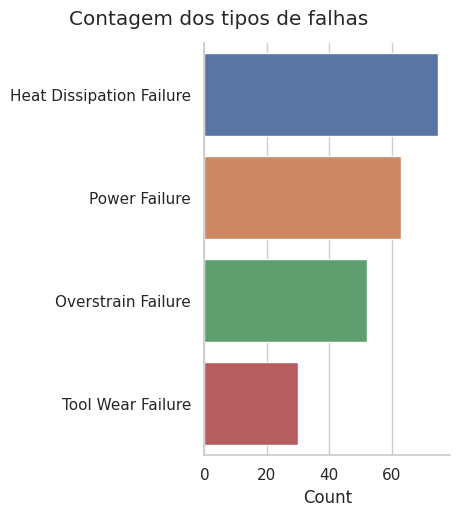

In [112]:
# Plotagem da contagem dos tipos de falhas
order = failure['failure_type'].value_counts().index
g = sns.catplot(y = 'failure_type', data = failure, kind = 'count', order = order)
g.set(xlabel="Count", ylabel= None)
g.fig.suptitle("Contagem dos tipos de falhas", y=1.03)
plt.show()

## Distribução das variáveis de interresse

Text(0.5, 1.03, 'Distribuição da variável process_temperature_k')

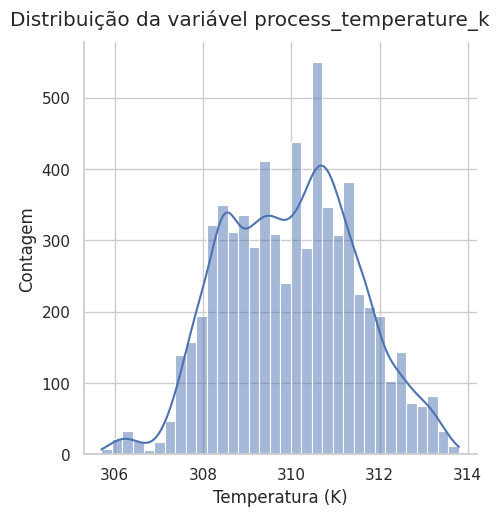

In [113]:
g = sns.displot(data=train, x="process_temperature_k", kde = True)
g.set(xlabel='Temperatura (K)', ylabel= 'Contagem')
g.fig.suptitle("Distribuição da variável process_temperature_k", y=1.03)

Text(0.5, 1.03, 'Distribuição da variável torque_nm')

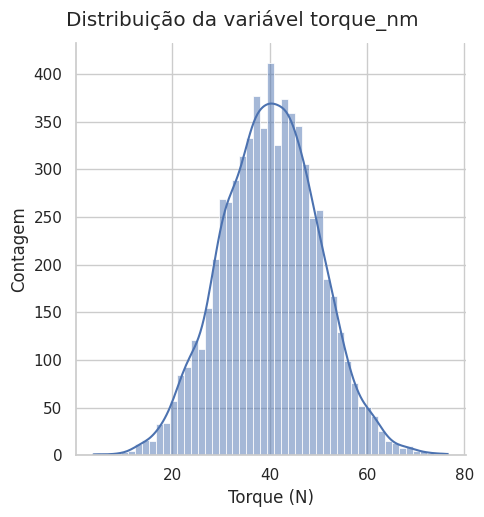

In [114]:
g = sns.displot(data=train, x="torque_nm", kde = True)
g.set(xlabel='Torque (N)', ylabel= 'Contagem')
g.fig.suptitle("Distribuição da variável torque_nm", y=1.03)

Text(0.5, 1.03, 'Distribuição da variável tool_wear_min')

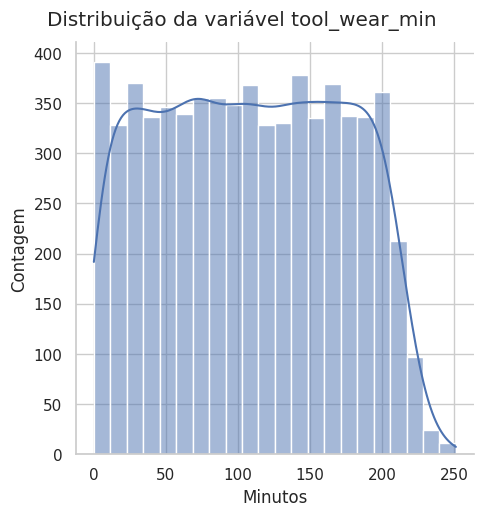

In [115]:
g = sns.displot(data=train, x="tool_wear_min", kde = True)
g.set(xlabel='Minutos', ylabel= 'Contagem')
g.fig.suptitle("Distribuição da variável tool_wear_min", y=1.03)

Text(0.5, 1.03, 'KDE da variável process_temperature_k por falha')

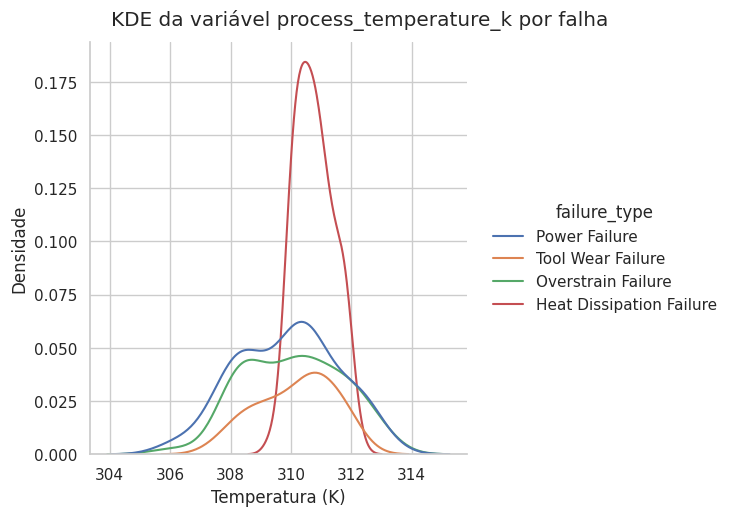

In [116]:
g = sns.displot(data=failure, x="process_temperature_k", hue="failure_type", kind="kde")
g.set(xlabel='Temperatura (K)',  ylabel= 'Densidade')
g.fig.suptitle("KDE da variável process_temperature_k por falha", y=1.03)

Text(0.5, 1.03, 'KDE da variável torque_nm por falha')

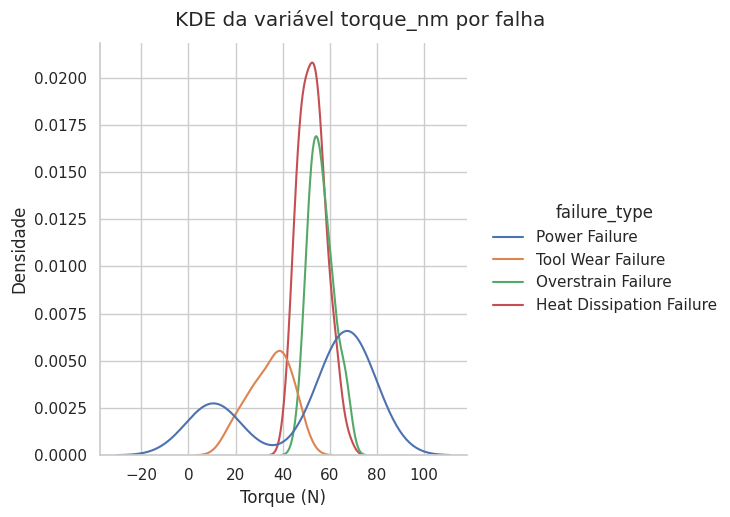

In [117]:
g = sns.displot(data=failure, x="torque_nm", hue="failure_type",  kind="kde")
g.set(xlabel='Torque (N)', ylabel= 'Densidade')
g.fig.suptitle("KDE da variável torque_nm por falha", y=1.03)

Text(0.5, 1.03, 'KDE da variável tool_wear_min por falha')

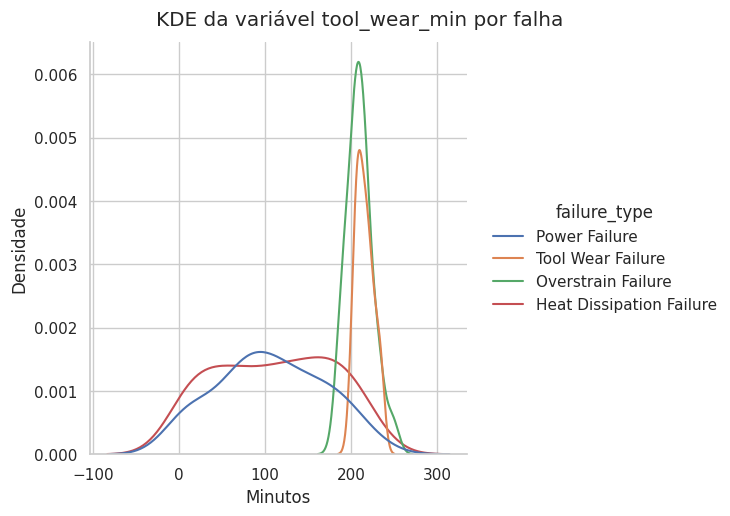

In [118]:
g = sns.displot(data=failure, x="tool_wear_min", hue="failure_type", kind="kde")
g.set(xlabel='Minutos',  ylabel= 'Densidade')
g.fig.suptitle("KDE da variável tool_wear_min por falha", y=1.03)

Observações:
* <code>process_temperature_k</code> e <code>torque_nm</code> se aproximam de uma distribuição normal, equanto <code>tool_wear_min</code> se aproxima de uma distribuição linear.
* A probabilidade de encontrar falhas de dissipação de calor é maior entre os valores de 309 K - 310 K.
* A probabilidade de encontrar falhas de esforço excessivoe e é maior proximo aos valores de 200 min.

## Qual modelo utilizar?

Aqui percebemos que estamos lidando com um problema de **Classificação com multiclasses** com um conjunto de dados desbalanceado. 

Nesse notebook vamos utilizar o classificador <a href="https://scikit-learn.org/stable/modules/tree.html">Decision Tree</a> , ou árvore de decisão. Uma árvore de decisão é construída dividindo um conjunto de dados em subsegmentos menores com base em certas condições em cada nível. A ideia é que toda vez que uma partição ou divisão é feita, amostras de dados semelhantes são agrupadas.

A decisão de como dividir depende da entropia e da informação obtida. A entropia refere-se à aleatoriedade no conjunto de dados, portanto, a árvore de decisão tenta fazer uma divisão que minimize o valor da entropia dos dados.

Os nós iniciais em uma árvore de decisão são os nós raiz, e todos os nós, onde as divisões são feitas, são chamados de nós de decisão. Os nós finais no final da árvore são os ‘nós folha’, que fornecem a previsão.

As vantagens incluem:

* Dimensionamento de recursos: não é necessário

* Outliers: Robusto

* Valores ausentes: identificadores embutidos

As desvantagens incluem:

* Overfitting: É propenso a overfitting, pois continua gerando nós para ajustar os dados e não consegue generalizar.

* Instável: A adição de novos dados pode levar à construção de uma nova árvore de decisão a partir do zero

* Uma grande quantidade de dados para treinamento: com poucos dados, o modelo tende a sofrer overfitting.

## Feature Preprocessing & Engineering

Para que o nosso modelo de Machine Learning processe nossos dados, é necessário que a nossa Label <code>'failure_type'</code> e para nossa feature <code>'type'</code>, que são variáveis categóricas, sejam convertidas em variáveis numéricas.
Para isso, vamos utilizar o <a href="https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html">o Label Encoder do scikit-learn</a>. Usando o código abaixo nos podemos verificar como vai ficar o mapeamento:

In [119]:
# visualizando o mapeamento para a variável 'failure_type'
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train['failure_type'])
le_name_map = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_map

{'Heat Dissipation Failure': 0,
 'No Failure': 1,
 'Overstrain Failure': 2,
 'Power Failure': 3,
 'Tool Wear Failure': 4}

In [120]:
# usando fit_transform para mapear os valores
train['failure_type'] = le.fit_transform(train['failure_type'])

In [121]:
# usando fit_transform para mapear os valores
train['type'] = le.fit_transform(train['type'])

Aqui está o tipo de dados atual das variáveis!

In [122]:
# verificando o novo tipo dos dados
train.dtypes

type                       int64
process_temperature_k    float64
torque_nm                float64
tool_wear_min              int64
failure_type               int64
dtype: object

In [123]:
train.head()

,type,process_temperature_k,torque_nm,tool_wear_min,failure_type
0,2,308.6,42.8,0,1
1,1,308.7,46.3,3,1
2,1,308.7,40.0,9,1
3,2,308.6,41.9,11,1
4,1,308.6,42.4,14,1


## Construindo o nosso modelo

### Train test split

Primeiro dividimos em X (features) e y (variável de interesse ou label) e depois vamos dividir em um conjunto para treinamento e avaliação.

In [124]:
# Importando bibliotecas
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

In [125]:
# Selecionando as features e as labels
X, y = train.drop(["failure_type"], axis=1), train[["failure_type"]].values.flatten()

### Lidando com os dados desbalanceados

Over-sampling é uma técnica que adiciona mais amostras de classes sub-representadas, o método que usaremos aqui é o <a href="https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html">SMOTE</a> (Synthetic Minority Oversampling Technique). 

O SMOTE funciona selecionando exemplos que estão próximos no espaço dos atributos, desenhando uma linha entre os exemplos no espaço dos atributos e desenhando uma nova amostra em um ponto ao longo dessa linha.

In [126]:
# Importando SMOTE da biblioteca imblearn
from imblearn.over_sampling import SMOTE

# Criando as novas amostras
smote = SMOTE(random_state = 0)
smote_X, smote_y = smote.fit_resample(X, y)

In [127]:
# Visualizando a nova amostragem
from imblearn.over_sampling._smote.base import Counter

print('Antes da nova amostragem de classes: ', Counter(y))
print('Depois da nova amostragem de classes: ', Counter(smote_y))

Antes da nova amostragem de classes:  Counter({1: 6435, 0: 75, 3: 63, 2: 52, 4: 30})
Depois da nova amostragem de classes:  Counter({1: 6435, 3: 6435, 4: 6435, 2: 6435, 0: 6435})


In [128]:
# Train test split
X_train, X_eval, y_train, y_eval = train_test_split(
    smote_X, smote_y, test_size=0.20, random_state=0)

### Decision Tree Classifier

In [129]:
# Aplicando nosso modelo 
dtree_model = DecisionTreeClassifier(max_depth = 5).fit(X_train, y_train)

In [130]:
# Prevendo os valores de validação
dtree_pred = dtree_model.predict(X_eval)

## Performace do modelo

### Matriz de confusão

Matriz de confusão sem normalização
[[1105   33  123    5    0]
 [ 147 1000   17   19   74]
 [  27    0 1239    1    0]
 [  20   21   89 1210    7]
 [  26    0    0    0 1272]]
Matriz de confusão normalizada
[[8.72827804e-01 2.60663507e-02 9.71563981e-02 3.94944708e-03
  0.00000000e+00]
 [1.16945107e-01 7.95544948e-01 1.35242641e-02 1.51153540e-02
  5.88703262e-02]
 [2.13101815e-02 0.00000000e+00 9.77900552e-01 7.89265983e-04
  0.00000000e+00]
 [1.48478099e-02 1.55902004e-02 6.60727543e-02 8.98292502e-01
  5.19673348e-03]
 [2.00308166e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
  9.79969183e-01]]


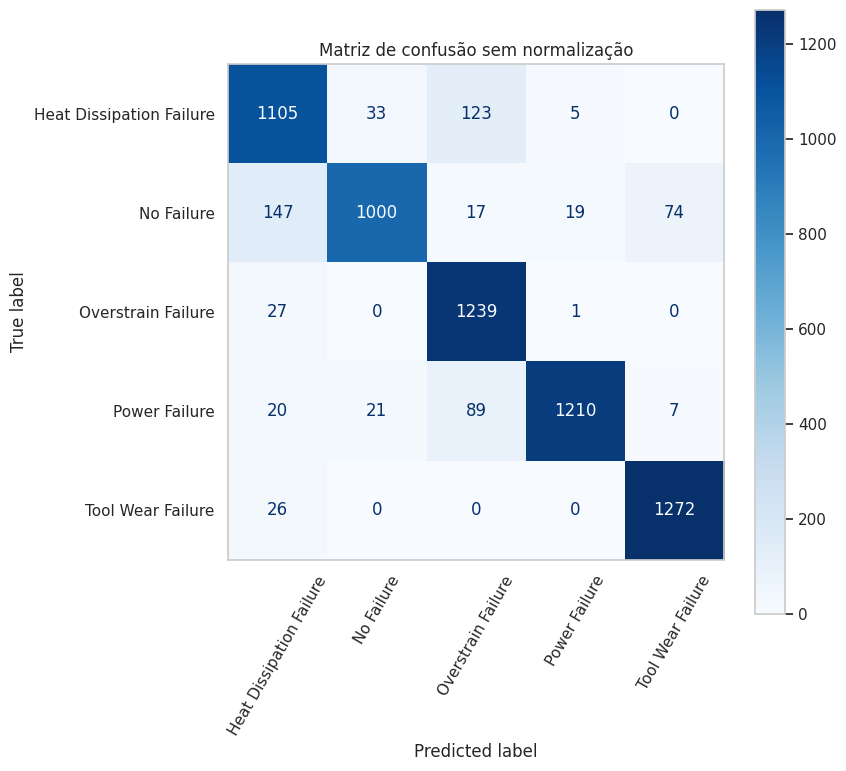

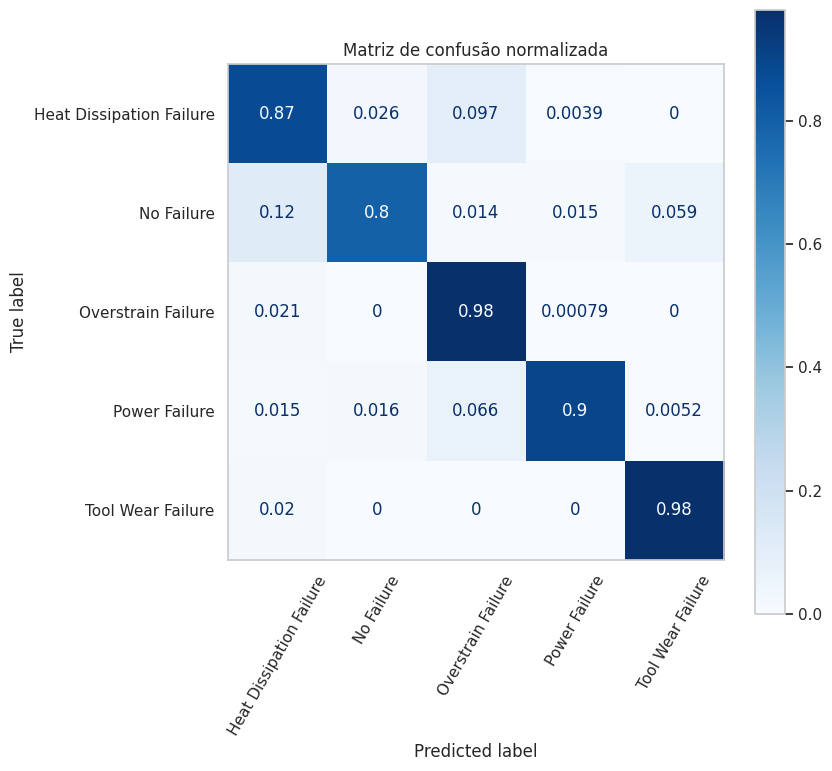

In [131]:
# save the target variable classes
class_names = le_name_map.keys()

titles_options = [
    ("Matriz de confusão sem normalização", None),
    ("Matriz de confusão normalizada", "true"),
]
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(8, 8))
    
    disp = ConfusionMatrixDisplay.from_estimator(
        dtree_model,
        X_eval,
        y_eval,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
        ax = ax
    )
    disp.ax_.set_title(title)
    disp.ax_.grid(False)
    plt.xticks(rotation = 60)

    print(title)
    print(disp.confusion_matrix)

A nossa matriz de confusão mostra valores bem concentrados na diagonal principal, o que geralmente é um bom sinal.

Alguns dados importantes:

* Dos <code>Heat Dissipation Failure</code> 123 pontos foram preditos como <code>Overstrain Failure</code>.
* Dos <code>No Failure</code> 147 pontos foram preditos como <code>Heat Dissipation Failure</code> e 74 como <code>Tool Wear Failure</code>.
* Dos <code>Power Failure</code> 89 pontos foram preditos como <code>Overstrain Failure</code>.

Além disso, a diagonal principal da matriz de confusão normalizada representa a precisão do nosso modelo, então ficamos com:

|falha|precisão|
|-|-|
|Heat Dissipation Failure|0.87|
|No Failure|0.80|
|Overstrain Failure|0.98|
|Power Failure|0.90|
|Tool Wear Failure|0.98|

### Relatório de classificação

O <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html">relatório de classificação</a>  mede a qualidade das previsões de um algoritmo.

Ele nos diz quantas previsões estão certas/erradas, mais especificamente, ele usa verdadeiros positivos, falsos positivos, verdadeiros negativos e falsos negativos para calcular as métricas de precisão, recuperação e pontuação f1.

In [132]:
print(classification_report(dtree_pred, y_eval))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1325
           1       0.80      0.95      0.87      1054
           2       0.98      0.84      0.91      1468
           3       0.90      0.98      0.94      1235
           4       0.98      0.94      0.96      1353

    accuracy                           0.91      6435
   macro avg       0.90      0.91      0.90      6435
weighted avg       0.91      0.91      0.91      6435



Observações:
* Obteve bom desempenho na capacidade de não rotular uma amostra negativa como positiva, já que os valores de precisão foram relativamente bons.
* Obteve bom desempenho na capacidade de encontrar todas as amostras positivas, uma vez que o recall foi alto em quase todas as classes.

### Importância das features

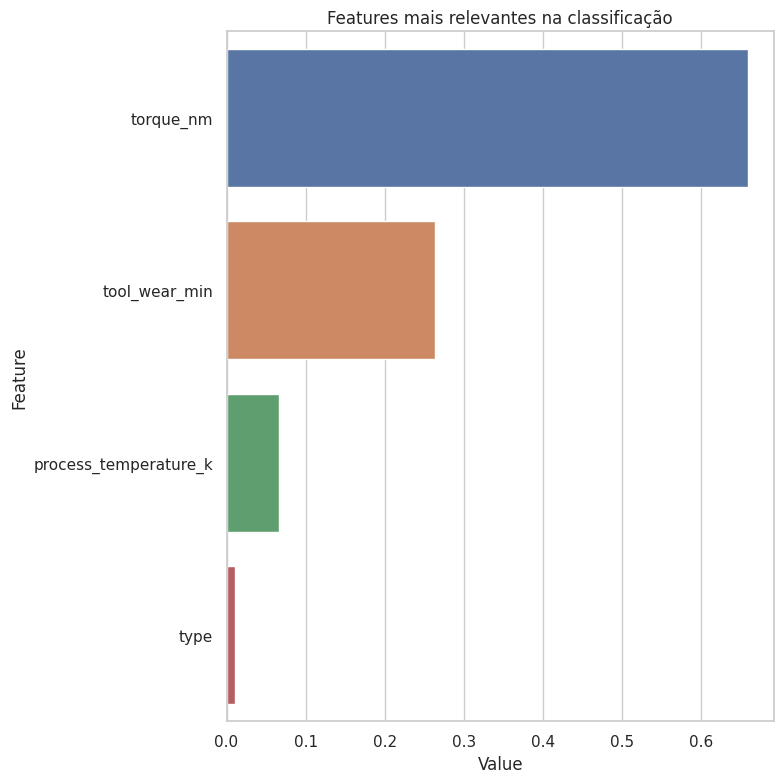

In [133]:
feature_imp = pd.DataFrame(sorted(zip(dtree_model.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(8, 8))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Features mais relevantes na classificação')
plt.tight_layout()

### Visualização do processo de decisão do classificador

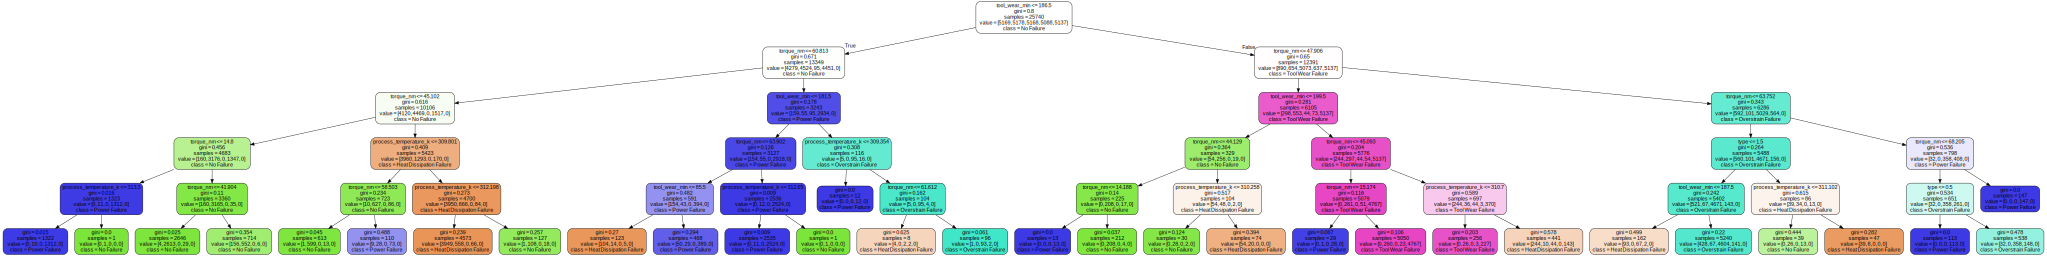

In [134]:
# Importando o graphviz
import graphviz

# Gerando o gráfico
dot_data = tree.export_graphviz(dtree_model, out_file=None, filled=True, rounded = True, feature_names=X.columns, class_names=list(class_names))
graph = graphviz.Source(dot_data)
graph

## Prevendo os valores de teste

In [135]:
# Carregando o arquivo de teste
data1 = pd.read_csv('/content/desafio_manutencao_preditiva_teste.csv')

In [136]:
# Primeiras cinco linhas do dataset
data1.head()

,udi,product_id,type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min
0,446,L47625,L,297.5,308.6,1793,26.7,70
1,7076,L54255,L,300.7,310.5,1536,47.4,192
2,1191,L48370,L,297.2,308.4,1460,42.1,41
3,2618,L49797,L,299.4,309.1,1670,35.9,68
4,5067,L52246,L,304.1,313.1,1550,30.9,9


In [137]:
# Selecionando as features
test = data1[categ+num]

In [138]:
# usando fit_transform para mapear os valores
test['type'] = le.fit_transform(test['type'])

# Primeiras cinco linhas
test.head()

,type,process_temperature_k,torque_nm,tool_wear_min
0,1,308.6,26.7,70
1,1,310.5,47.4,192
2,1,308.4,42.1,41
3,1,309.1,35.9,68
4,1,313.1,30.9,9


In [139]:
# Selecionando os valores numéricos e transformando em dataset
rowNumbers = data1.index.values
rowNumbers = pd.DataFrame(rowNumbers, columns=['rowNumber'])
rowNumbers

,rowNumber
0,0
1,1
2,2
3,3
4,4
...,...
3328,3328
3329,3329
3330,3330
3331,3331


In [140]:
# Concatenando os datasets
test_preds = dtree_model.predict(test)
submission_df = pd.concat([rowNumbers, pd.DataFrame(test_preds, columns=['predictedValues'])], axis=1)
submission_df.head()

,rowNumber,predictedValues
0,0,1
1,1,0
2,2,1
3,3,1
4,4,1


In [141]:
# Visualização do mapeamento
le_name_map

{'Heat Dissipation Failure': 0,
 'No Failure': 1,
 'Overstrain Failure': 2,
 'Power Failure': 3,
 'Tool Wear Failure': 4}

In [142]:
# Atribuindo o mapeamento a variável inv_map
inv_map = {v: k for k, v in le_name_map.items()}
inv_map

{0: 'Heat Dissipation Failure',
 1: 'No Failure',
 2: 'Overstrain Failure',
 3: 'Power Failure',
 4: 'Tool Wear Failure'}

In [143]:
# Mapeamento
submission_df['predictedValues'] = submission_df['predictedValues'].map(inv_map)  
submission_df.head()

,rowNumber,predictedValues
0,0,No Failure
1,1,Heat Dissipation Failure
2,2,No Failure
3,3,No Failure
4,4,No Failure


In [144]:
# Verificando a predição dos valores
submission_df['predictedValues'].value_counts()

No Failure                  2568
Heat Dissipation Failure     424
Tool Wear Failure            206
Power Failure                 70
Overstrain Failure            65
Name: predictedValues, dtype: int64

Como na nossa documentação é dito que cada processo tem uma chance de 0,1% de falhar independentemente de seus parâmetros de processo. Então vamos escolher 0.1% dos equipamentos sem falha, de forma aleatória, e atribuir uma falha aleatória.

In [145]:
submission_df.loc[submission_df.query('predictedValues == "No Failure"').sample(frac=0.001).index, 'predictedValues'] = 'Random Failure'

In [146]:
# Verificando os novos valores
submission_df['predictedValues'].value_counts()

No Failure                  2565
Heat Dissipation Failure     424
Tool Wear Failure            206
Power Failure                 70
Overstrain Failure            65
Random Failure                 3
Name: predictedValues, dtype: int64

In [147]:
# Gerando o arquivo com as predições sem index
submission_df.to_csv('predicted.csv', index=False)